## Henso-Jutsu 101

* 🔮"More than merely just putting on a costume, ninjutsu's disguise system involved thoroughly impersonating the character adopted." 🔮


* The basic idea is to generate adversarial images to make machine learning predict wrong.
  * <b>When the images are small to a certain level, the adversarial images can look exactly the same as the original image.</b> But the adversarial image will just be predicted wrong. I think this is amazing! 🌺



* `keras.applications` provides models that have pretrained weights
* All the ImageNet labels can be found in : https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
* ImageNet Egyptian Cats: http://www.image-net.org/synset?wnid=n02124075#
  * You need to ait a bit, images loading may needs sometime

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import foolbox
import keras
import numpy as np
from keras.applications import resnet50

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

In [121]:
# instantiate model
keras.backend.set_learning_phase(0)
kmodel = resnet50.ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)  # The values here are the values of ImageNet pictures
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

In [122]:
from PIL import Image

label = 285  # 285  is "Egyptian Cat" in ImageNet

# Printout the image. By default, resnet50 expects (224, 224)
def read_testimage(path, shape=(224, 224), data_format='channels_last'):

    image = Image.open(path)
    image = image.resize(shape)
    image = np.asarray(image, dtype=np.float32)
    image = image[:, :, :3]
    assert image.shape == shape + (3,)
    if data_format == 'channels_first':
        image = np.transpose(image, (2, 0, 1))
    return image

# Predict the image with Keras
def predict_image_label(img, pretrained_model):
    image_batch = np.expand_dims(img, axis=0)

    # prepare the image for the RestNet50 model
    processed_image = resnet50.preprocess_input(image_batch.copy())

    # get the predicted probabilities for each class
    predictions = pretrained_model.predict(processed_image)

    # convert the probabilities to class labels
    # We will get top 5 predictions which is the default
    label = decode_predictions(predictions)
    
    return label

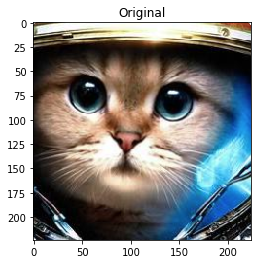

In [123]:
# get source image and label
image = read_testimage('baby_cat.png')

plt.figure()
plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]

In [124]:
print(image.shape)

(224, 224, 3)


In [7]:
# apply attack on source image
# ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
attack = foolbox.attacks.SaliencyMapAttack(fmodel)
adversarial= attack(image[:, :, ::-1], label) # if the attack fails, adversarial will be None

/Users/hanhanwu/anaconda/envs/conda_virtualenv/lib/python2.7/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


#### NOTE!
* If you use `image[:, ::-1, :]`, it will change the second channel, it will reverse the image horientically
* If you use `image[::-1, :, :]`, it will change the first channel, it will reverse the image vertically

#### As we can see from above, if the model is already misclassified, adversarial arrack won't happen...

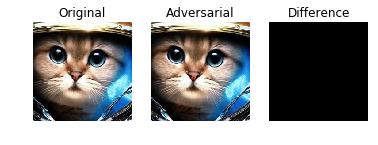

In [126]:
plt.figure()

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference)
plt.axis('off')

plt.show()

In [127]:
# Because adversarial didin't happen, nothing changed
difference[7:9] 

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [129]:
# Let's see why it gets misclassified
original_labels = predict_image_label(image, kmodel)
print original_labels

[[(u'n03127747', u'crash_helmet', 0.83045), (u'n03379051', u'football_helmet', 0.039096683), (u'n03793489', u'mouse', 0.02106579), (u'n02909870', u'bucket', 0.012218378), (u'n02939185', u'caldron', 0.008351621)]]


### Prediction Result:

(-0.5, 223.5, 223.5, -0.5)

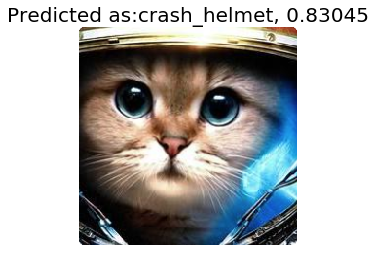

In [130]:
original_top_pred = original_labels[0][0]
plt.title('Predicted as:' + original_top_pred[1] + ', ' + str(original_top_pred[2]), fontsize=20)
plt.imshow(image / 255)
plt.axis('off')

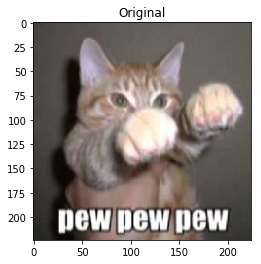

In [131]:
# get source image and label
image = read_testimage('baby_cat2.png')

plt.figure()
plt.title('Original')
plt.imshow(image / 255)

In [132]:
# Gradient based attack
# This is GradientSignAttack
# it will adds the sign of the gradient to the image, gradually increasing the magnitude until the image is misclassified.
attack = foolbox.attacks.FGSM(fmodel)
adversarial= attack(image[:, :, ::-1], label)

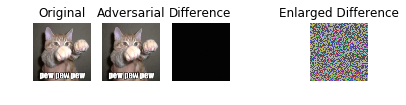

In [133]:
plt.figure()

plt.subplot(1, 5, 1)
plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(abs(difference))
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title('Enlarged Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [134]:
difference[7:9]  # At least this time it does classified as "Egyptian cat"

array([[[-0.01274872, -0.01274872, -0.01274872],
        [-0.01274872, -0.01274872, -0.01274872],
        [ 0.01274872,  0.01274872, -0.01274872],
        ...,
        [-0.01274872, -0.01274872, -0.01274872],
        [-0.01274872, -0.01274872, -0.01274872],
        [-0.01274872, -0.01274872,  0.01274872]],

       [[ 0.01274872,  0.01274872, -0.01274872],
        [ 0.01274872,  0.01274872, -0.01274872],
        [ 0.01274872,  0.01274872,  0.01274872],
        ...,
        [-0.01274872, -0.01274872, -0.01274872],
        [-0.01274872, -0.01274872, -0.01274872],
        [-0.01274872, -0.01274872, -0.01274872]]], dtype=float32)

In [135]:
original_labels = predict_image_label(image, kmodel)
print original_labels

adversarial_labels = predict_image_label(adversarial[:, :, ::-1], kmodel)
print adversarial_labels

[[(u'n02124075', u'Egyptian_cat', 0.35402814), (u'n02123045', u'tabby', 0.30671296), (u'n02123159', u'tiger_cat', 0.13006069), (u'n02443114', u'polecat', 0.039734777), (u'n02127052', u'lynx', 0.022744766)]]
[[(u'n02123045', u'tabby', 0.32370746), (u'n02124075', u'Egyptian_cat', 0.3089996), (u'n02123159', u'tiger_cat', 0.13459267), (u'n02443114', u'polecat', 0.046001658), (u'n02127052', u'lynx', 0.023560978)]]


### Prediction Results

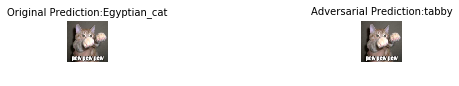

In [144]:
plt.figure()

plt.subplot(1, 7, 1)
original_top_pred = original_labels[0][0]
plt.title('Original Prediction:' + original_top_pred[1], fontsize=10)
plt.imshow(image / 255)
plt.axis('off')

plt.subplot(1, 7, 7)
adv_top_pred = adversarial_labels[0][0]
plt.title('Adversarial Prediction:' + adv_top_pred[1], fontsize=10)
plt.imshow(image / 255)
plt.axis('off')

plt.show()

In [145]:
# Decision based attack
# This is BlendedUniformNoiseAttack
# It will blend the image with a uniform noise image until it is misclassified.
attack = foolbox.attacks.BlendedUniformNoiseAttack(fmodel)
adversarial= attack(image[:, :, ::-1], label)

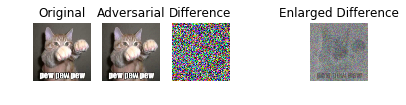

In [146]:
plt.figure()

plt.subplot(1, 5, 1)
plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(abs(difference))
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title('Enlarged Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [147]:
# But still, got predicted right...
original_labels = predict_image_label(image, kmodel)
print original_labels

adversarial_labels = predict_image_label(adversarial[:, :, ::-1], kmodel)
print adversarial_labels

[[(u'n02124075', u'Egyptian_cat', 0.35402814), (u'n02123045', u'tabby', 0.30671296), (u'n02123159', u'tiger_cat', 0.13006069), (u'n02443114', u'polecat', 0.039734777), (u'n02127052', u'lynx', 0.022744766)]]
[[(u'n02123045', u'tabby', 0.32233274), (u'n02124075', u'Egyptian_cat', 0.3127098), (u'n02123159', u'tiger_cat', 0.15299194), (u'n02127052', u'lynx', 0.041714206), (u'n02443114', u'polecat', 0.030645782)]]


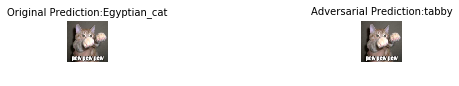

In [148]:
plt.figure()

plt.subplot(1, 7, 1)
original_top_pred = original_labels[0][0]
plt.title('Original Prediction:' + original_top_pred[1], fontsize=10)
plt.imshow(image / 255)
plt.axis('off')

plt.subplot(1, 7, 7)
adv_top_pred = adversarial_labels[0][0]
plt.title('Adversarial Prediction:' + adv_top_pred[1], fontsize=10)
plt.imshow(image / 255)
plt.axis('off')

plt.show()

In [149]:
# Decision based attack
# This is GaussianBlurAttack
# It will blur the image until it is misclassified.
attack = foolbox.attacks.GaussianBlurAttack(fmodel)
adversarial= attack(image[:, :, ::-1], label)

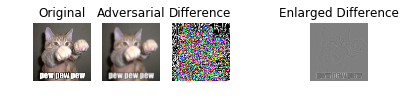

In [150]:
plt.figure()

plt.subplot(1, 5, 1)
plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(abs(difference))
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title('Enlarged Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [152]:
# But still, got predicted right...
original_labels = predict_image_label(image, kmodel)
print original_labels

adversarial_labels = predict_image_label(adversarial[:, :, ::-1], kmodel)
print adversarial_labels

[[(u'n02124075', u'Egyptian_cat', 0.35402814), (u'n02123045', u'tabby', 0.30671296), (u'n02123159', u'tiger_cat', 0.13006069), (u'n02443114', u'polecat', 0.039734777), (u'n02127052', u'lynx', 0.022744766)]]
[[(u'n02097047', u'miniature_schnauzer', 0.11995507), (u'n02095889', u'Sealyham_terrier', 0.08646894), (u'n02124075', u'Egyptian_cat', 0.07775854), (u'n02443114', u'polecat', 0.04975023), (u'n02123045', u'tabby', 0.03974096)]]


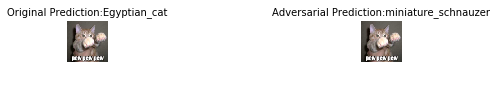

In [153]:
plt.figure()

plt.subplot(1, 7, 1)
original_top_pred = original_labels[0][0]
plt.title('Original Prediction:' + original_top_pred[1], fontsize=10)
plt.imshow(image / 255)
plt.axis('off')

plt.subplot(1, 7, 7)
adv_top_pred = adversarial_labels[0][0]
plt.title('Adversarial Prediction:' + adv_top_pred[1], fontsize=10)
plt.imshow(image / 255)
plt.axis('off')

plt.show()

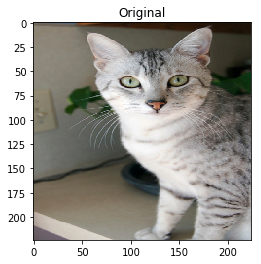

In [154]:
# This is a typical "Egyptian Cat" from ImageNet
image = read_testimage('cat.png')

plt.figure()
plt.title('Original')
plt.imshow(image / 255)

In [155]:
attack = foolbox.attacks.BlendedUniformNoiseAttack(fmodel)
adversarial= attack(image[:, :, ::-1], label)

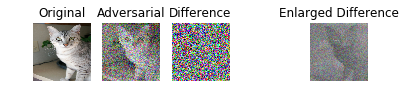

In [156]:
plt.figure()

plt.subplot(1, 5, 1)
plt.title('Original')
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 5, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 5, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(abs(difference))
plt.axis('off')

plt.subplot(1, 5, 5)
plt.title('Enlarged Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [157]:
# But still, got predicted right...
original_labels = predict_image_label(image, kmodel)
print original_labels

adversarial_labels = predict_image_label(adversarial[:, :, ::-1], kmodel)
print adversarial_labels

[[(u'n02124075', u'Egyptian_cat', 0.8930785), (u'n02123045', u'tabby', 0.08075293), (u'n02123159', u'tiger_cat', 0.015799433), (u'n02127052', u'lynx', 0.0032189174), (u'n03085013', u'computer_keyboard', 0.00089720037)]]
[[(u'n02454379', u'armadillo', 0.122340985), (u'n01498041', u'stingray', 0.12183102), (u'n02120505', u'grey_fox', 0.12170664), (u'n02124075', u'Egyptian_cat', 0.11485421), (u'n02114548', u'white_wolf', 0.090845026)]]


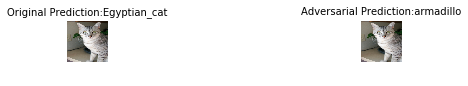

In [158]:
plt.figure()

plt.subplot(1, 7, 1)
original_top_pred = original_labels[0][0]
plt.title('Original Prediction:' + original_top_pred[1], fontsize=10)
plt.imshow(image / 255)
plt.axis('off')

plt.subplot(1, 7, 7)
adv_top_pred = adversarial_labels[0][0]
plt.title('Adversarial Prediction:' + adv_top_pred[1], fontsize=10)
plt.imshow(image / 255)
plt.axis('off')

plt.show()

## Summary

* Attacks in Foobox: https://foolbox.readthedocs.io/en/latest/modules/attacks.html
  * I tried all the attacks here, finally the methods I used here are better. They are much faster than other methods, and won't stop until there is misclassification. As you can see, when I am using Keras pretrained model to predict both original and adversarial images, original image will always be predicte right, while adversarial images will be predicted wrong!
  * The amazing thing is, through human eyes, the adversarial images can look almost the same as the original image.
  
* I have also tried to wrong the same code on Mac and Windows, very weird, my windows has the latest Tensorflow, twice larger RAM and much much more memory, it was slower than my mac... and finally exactly same code will simply give error on my windows. There maybe bugs in Tensorflow.